In [2]:
import pandas as pd

#cargamos el dataset
data = pd.read_excel('Sales_Data.xlsx')
print(data.head())

  Order Date      Sales
0 2015-01-01  14205.707
1 2015-02-01   4519.892
2 2015-03-01  55205.797
3 2015-04-01  27906.855
4 2015-05-01  23644.303


In [4]:
#convertimos la columna de fecha a tipo datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])

#agrupamos por mes y sumar las ventas
data.set_index('Order Date', inplace=True)
monthly_sales = data.resample('M').sum()

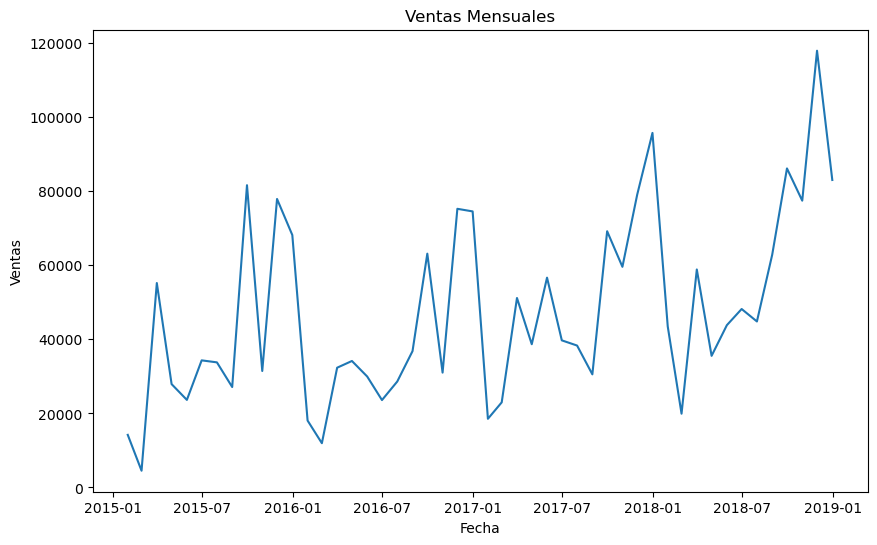

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales['Sales'])
plt.title('Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

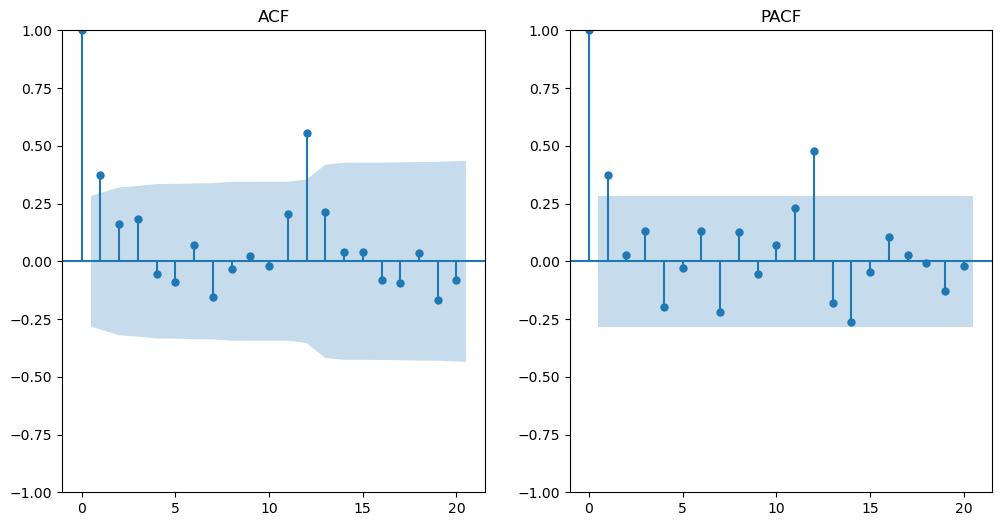

In [6]:
#identificamos los parametros ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(monthly_sales['Sales'].dropna(), lags=20, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(monthly_sales['Sales'].dropna(), lags=20, ax=plt.gca())
plt.title('PACF')
plt.show()

In [9]:
#ahora realizamos la prueba de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(monthly_sales['Sales'])
print(f'Estadístico de prueba: {resultado[0]}')
print(f'Valor p: {resultado[1]}')

#si el valor p es mayor a 0.05, se diferencia la serie
if resultado[1] > 0.05:
    print("La serie no es estacionaria, debe diferenciarse.")
    #aqui diferenciamos
    monthly_sales['Sales'] = monthly_sales['Sales'].diff().dropna()
    d = 1  #en caso que se ha diferenciado al menos 1 vez
else:
    print("La serie es estacionaria.")
    d = 0  #no necesita diferenciacion

Estadístico de prueba: -4.41613676143077
Valor p: 0.00027791039276670493
La serie es estacionaria.


In [10]:
#modelado con ARIMA
p = 1  #reemplaza con el valor correcto basado en el grafico de PACF
q = 1  #reemplaza con el valor correcto basado en el grafico de ACF
#ajustamos el modelo ARIMA Basado en los parametros p, d, y  q identificados.
from statsmodels.tsa.arima.model import ARIMA

#definimos el modelo (ajusta los valores p, d, q)
modelo = ARIMA(monthly_sales['Sales'], order=(p, d, q))
modelo_ajustado = modelo.fit()

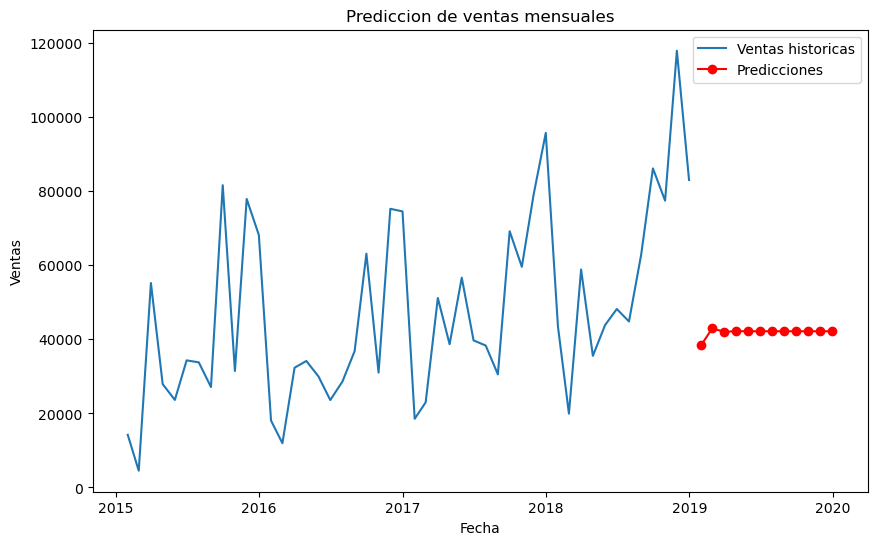

In [28]:
#ahora podemos revisar predicciones en los proximos meses

#predecimos los 12 meses
predicciones = modelo_ajustado.forecast(steps=12)

#creamos el rango
predicciones_index = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1), 
                                    periods=12, freq='M')

# Visualizar las predicciones
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales['Sales'], label='Ventas historicas')
plt.plot(predicciones_index, predicciones, label='Predicciones', color='red', marker='o')
plt.title('Prediccion de ventas mensuales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


In [29]:
#evaluamos nuestras predicciones
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales['Sales'][:train_size], monthly_sales['Sales'][train_size:]

#ajutsamos el modelo con el conjunto de entrenamiento
modelo = ARIMA(train, order=(p, d, q))
modelo_ajustado = modelo.fit()

In [30]:

#realizamos predicciones sobre el conjunto de prueba
predicciones_test = modelo_ajustado.forecast(steps=len(test))

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, predicciones_test)
mae = mean_absolute_error(test, predicciones_test)

print(f'Error (MSE): {mse}')
print(f'Error  (MAE): {mae}')

Error (MSE): 1153031860.3914983
Error  (MAE): 25478.756170283177


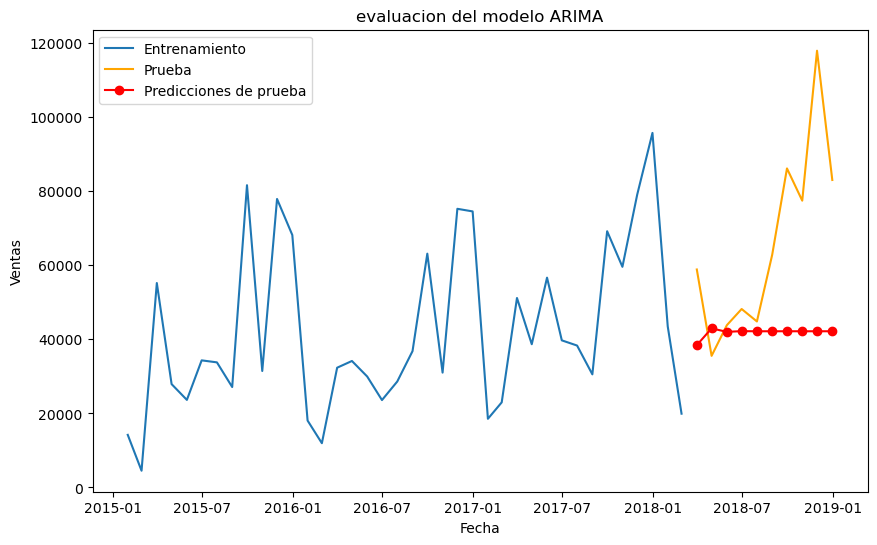

In [27]:
# Visualizar las predicciones de prueba
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(test.index, predicciones_test, label='Predicciones de prueba', color='red', marker='o')
plt.title('evaluacion del modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()